In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [9]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
df = pd.read_csv (r'/content/drive/My Drive/Data/Smartbox/Smartbox_Outliers_Removed.csv' )


In [0]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
df.head()

,date,daily_forecast,daily_sales,month,year,day,product_name,daily_forecast_zscore,daily_sales_zscore
0,2017-01-01,39000,40608.0,1,2017,Sunday,Product A,2.197565,1.864841
1,2017-01-02,91000,95839.2,1,2017,Monday,Product A,1.066145,0.715437
2,2017-01-03,106000,104976.0,1,2017,Tuesday,Product A,0.739774,0.525293
3,2017-01-04,113000,120771.0,1,2017,Wednesday,Product A,0.587468,0.196587
4,2017-01-05,135000,141102.0,1,2017,Thursday,Product A,0.108790,0.226517


##Modelling on ONE product "Product A" 

In [0]:
df_product_A = df[df['product_name'] == 'Product A']
df_product_A.shape
df_product_A.set_index ('date', inplace = True)

#####Splitting the data

In [0]:
#Splitting the data with the date
#train_dataset = df_product_A[(df_product_A.index < last_5pct)]
#test_dataset = df_product_A[(df_product_A.index >= last_5pct)]

### Shuffling the dataset

In [0]:
dataset_drop = df_product_A.drop(['daily_forecast', 'daily_forecast_zscore', 'daily_sales_zscore'], axis = 1)
                                 




In [0]:
from sklearn.utils import shuffle
dataset_random = shuffle(dataset_drop,random_state = 45)

In [0]:
dataset_label = dataset_random.pop('daily_sales')

### Sorting and spittig data

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [0]:
train_dataset_random, test_dataset_random, train_label, test_label = train_test_split(dataset_random, dataset_label, test_size=0.2,
                                                  random_state=42)

### Assigining the target variable

### Convert categorical columns with one hot encoding

In [0]:
train_dataset_random_string = pd.get_dummies (train_dataset_random.astype(str))
test_dataset_random_string = pd.get_dummies (test_dataset_random.astype(str))

In [23]:
print ("Train",train_dataset_random_string.shape)
print ("Test",test_dataset_random_string.shape)
print ("Test",train_label.shape)
print ("Test",test_label.shape)

Train (552, 22)
Test (138, 22)
Test (552,)
Test (138,)


##### All the columns in the dataframe are categorical so converting whole dataframe into string

### Applying K-FOLD splitting

In [0]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold  # u should do STANDARD SCALER HERE feature scaling
def run_kfold(reg):
    kf = KFold (n_splits = 8, shuffle = True, random_state = 45)
     
    outcomes = []
    fold = []
    for train_index, test_index in kf.split (train_dataset_random_string, train_label):
        #fold +=1
        X_train, X_test = train_dataset_random_string.iloc[train_index] , train_dataset_random_string.iloc[test_index]
        y_train, y_test = train_label.iloc[train_index], train_label.iloc[test_index]
        reg.fit (X_train,y_train)
        y_pred = reg.predict (X_test)
        accuracy = np.sqrt (mean_squared_error (y_test,y_pred))
        outcomes.append (accuracy)
        print("Fold  accuracy: {}".format(accuracy))
    mean_outcome = np.mean (outcomes)
    print ("Mean Accuracy {}" . format (mean_outcome))


### Testing with Linear Regression

In [25]:
reg = LinearRegression(normalize=True)
run_kfold (reg)

Fold  accuracy: 29391.108634965873
Fold  accuracy: 31088.2792444032
Fold  accuracy: 20846.069913961437
Fold  accuracy: 28020.203824911212
Fold  accuracy: 26686.23562716775
Fold  accuracy: 29035.094554166746
Fold  accuracy: 22252.708393886514
Fold  accuracy: 27537.85042480935
Mean Accuracy 26857.19382728401


### Testing with Random Forest Regressor

In [26]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(random_state = 1, n_estimators = 10)
run_kfold (reg)

Fold  accuracy: 27601.581530541866
Fold  accuracy: 26577.36827027914
Fold  accuracy: 18524.789420502322
Fold  accuracy: 26001.54157555469
Fold  accuracy: 22979.693665088904
Fold  accuracy: 28775.76606309783
Fold  accuracy: 24925.23239303813
Fold  accuracy: 23334.938012714996
Mean Accuracy 24840.113866352236


###Testing with XGBoost

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor (random_state=1)
run_kfold (reg)

Fold  accuracy: 27452.165500596006
Fold  accuracy: 26161.473409059883
Fold  accuracy: 15757.827733812206
Fold  accuracy: 24073.91104040388
Fold  accuracy: 22522.555807391862
Fold  accuracy: 24223.113640115615
Fold  accuracy: 21729.420498476524
Fold  accuracy: 23761.66742419173
Mean Accuracy 23210.266881755964


#### After analysing the RMSE from K-Fold splitting  XGBoost and Random Forest gives better predictions than other regressor techniques

####Model Optimization on whole dataset

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn import metrics

rmse_scorer = make_scorer(metrics.mean_absolute_error, greater_is_better=False)

pipe = Pipeline([("regressor", None)])

gbt = GradientBoostingRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)


parameters = [{"regressor": [rf],
               "regressor__n_estimators": range(20, 150, 25),
               "regressor__max_depth": range(10, 30, 5)
               },
              {"regressor": [gbt],
               "regressor__n_estimators": range(100, 500, 25),
               "regressor__max_depth": range(3, 5)}
              ]


grid_search = GridSearchCV(pipe, parameters, cv=5, scoring=rmse_scorer)
grid_search.fit(train_dataset_random_string, train_label)

print(grid_search.cv_results_)
print(grid_search.best_estimator_)

{'mean_fit_time': array([0.01901364, 0.04160061, 0.06151953, 0.0814857 , 0.10263572,
       0.12535996, 0.02094593, 0.04706793, 0.07183213, 0.09438291,
       0.12035394, 0.1458364 , 0.02216568, 0.04778843, 0.07228942,
       0.09771261, 0.12203832, 0.14574671, 0.02159286, 0.04734392,
       0.07123337, 0.09921784, 0.1215745 , 0.14708176, 0.0336484 ,
       0.04030099, 0.04833612, 0.05427656, 0.06309581, 0.07484465,
       0.07856216, 0.0861671 , 0.09811425, 0.10160465, 0.10983987,
       0.11804695, 0.12641716, 0.13396282, 0.14198108, 0.14772844,
       0.04550667, 0.0564805 , 0.06319046, 0.07365746, 0.08469601,
       0.0941339 , 0.10517488, 0.11499357, 0.12724233, 0.13566322,
       0.14580011, 0.15647831, 0.16824799, 0.18417034, 0.18974771,
       0.19755716]), 'std_fit_time': array([9.39316252e-04, 1.88235236e-03, 8.00930510e-04, 3.90279356e-04,
       6.53047500e-04, 1.82721592e-03, 8.30155005e-05, 3.83128152e-03,
       3.05260980e-03, 1.69954461e-03, 1.54558879e-03, 4.06451748e

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [0]:
  reg = grid_search.best_estimator_

In [30]:
reg

Pipeline(memory=None,
         steps=[('regressor',
                 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse',
                                           init=None, learning_rate=0.1,
                                           loss='ls', max_depth=4,
                                           max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=None,
                                           presort='auto', random_state=42,
                                           subsample=1.0, tol

In [0]:
reg.fit(train_dataset_random_string, train_label)
y_pred_train = reg.predict(train_dataset_random_string)


In [32]:
print("RMSE on Training data", np.sqrt(metrics.mean_squared_error(train_label, y_pred_train)))
print("MAE on Training data ", metrics.mean_absolute_error(train_label, y_pred_train))

RMSE on Training data 18015.17708641484
MAE on Training data  10424.472636586102


In [33]:
print ( "Test dataset shape"  ,test_dataset_random_string.shape)
print ( "Train dataset shape"  ,train_dataset_random_string.shape)

Test dataset shape (138, 22)
Train dataset shape (552, 22)


##Applying model on the test dataset

In [0]:
y_pred_test = reg.predict(test_dataset_random_string)



In [45]:
print("RMSE on Test data ", np.sqrt(metrics.mean_squared_error(test_label,
                                                             y_pred_test)))
print("MAE on Test data", metrics.mean_absolute_error(test_label,
                                                            y_pred_test))

RMSE_A = np.sqrt(metrics.mean_squared_error(test_label,y_pred_test))
MAE_A =  np.sqrt(metrics.mean_absolute_error(test_label,y_pred_test))
RMSE_B = np.sqrt(metrics.mean_squared_error(test_label,y_pred_test))
MAE_B =  np.sqrt(metrics.mean_absolute_error(test_label,y_pred_test))

RMSE on Test data  25978.771141950543
MAE on Test data 13756.755764879228


### Plot prediction vs ground truth

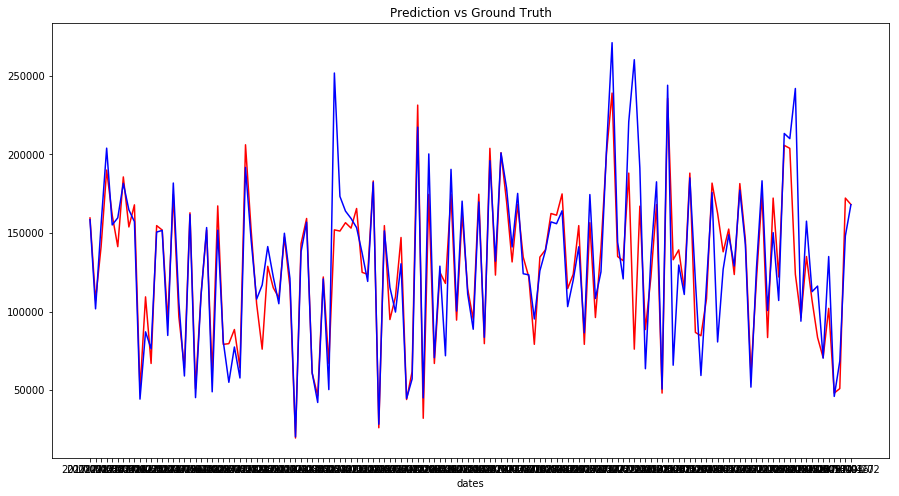

In [43]:
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.plot (y_pred_test, color = 'r')
ax = plt.plot (test_label, color = 'b')
plt.title ("Prediction vs Ground Truth")
plt.xlabel ('dates')
plt.show()